# First ICU Prediction using Logistic Regression

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
np.set_printoptions(precision=2)

import pandas as pd
import pickle
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import interp, stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

from utils.splits import set_two_splits
from utils.metrics import BinaryAvgMetrics, get_best_model
from utils.plots import *
from args import args
vars(args)

{'path': PosixPath('../data'),
 'workdir': PosixPath('../data/work_dir/lr'),
 'dataset_csv': PosixPath('../data/processed_dataset.csv'),
 'cols': ['class_label', 'scispacy_note'],
 'modeldir': PosixPath('../data/work_dir/lr/models'),
 'min_freq': 3,
 'bc_threshold': 0.47,
 'start_seed': 127}

## LR Model Dev

In [ ]:
seed = 42
ori_df = pd.read_csv(args.dataset_csv, usecols=args.cols)
df = set_two_splits(ori_df.copy(), 'test', seed=seed)

vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True,\
                              ngram_range=(2,2))
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['scispacy_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['scispacy_note'])
y_train = df.loc[(df['split'] == 'train')]['class_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['class_label'].to_numpy()

In [ ]:
clf = LogisticRegression(dual=True, class_weight='balanced', solver='liblinear', C=1.5)
clf.fit(x_train, y_train)
prob = clf.predict_proba(x_test)[:, 1]

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plot_thresh_range(ax, y_test, prob, 0.3, 0.7, 25)

In [ ]:
y_pred = (prob > 0.47).astype(np.int64)
cm = confusion_matrix(y_test, y_pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
prevalence = (fn+tp)/(tn+fp+fn+tp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'prevalence': np.round(prevalence, 3),  
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

plot_confusion_matrix(ax[0], cm, classes=['not imminent', 'imminent'], normalize=False, title='Confusion matrix')
plot_confusion_matrix(ax[1], cm, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
print_top_words(vectorizer.get_feature_names(), clf.coef_[0]/np.sum(clf.coef_[0]), 20)

## 100 Seed Run

In [ ]:
ori_df = pd.read_csv(args.dataset_csv, usecols=args.cols)
preds = []
targs = []
probs = []

for seed in range(args.start_seed, args.start_seed + 100):
  if seed % 10 == 0:
    print(f"Running classifier with seed {seed}")
  df = set_two_splits(ori_df.copy(), 'test', seed=seed)
  vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, ngram_range=(2,2))
  
  x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['scispacy_note'])
  x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['scispacy_note'])
  
  y_train = df.loc[(df['split'] == 'train')]['class_label'].to_numpy()
  y_test = df.loc[(df['split'] == 'test')]['class_label'].to_numpy()
  targs.append(y_test)
  
  clf = LogisticRegression(dual=True, class_weight='balanced', solver='liblinear', C=1.5)
  clf.fit(x_train, y_train)  
  pickle.dump(clf, open(args.modeldir/f'lr_seed_{seed}.pkl', 'wb'))
  
  pos_prob = clf.predict_proba(x_test)[:, 1]
  probs.append(pos_prob)
  
  y_pred = (pos_prob > args.bc_threshold).astype(np.int64)
  preds.append(y_pred)

with open(args.workdir/f'preds.pkl', 'wb') as f:
  pickle.dump(targs, f)
  pickle.dump(preds, f)
  pickle.dump(probs, f)

## Metrics

Taken from [here](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/):

1. Prevalence: `(fn + tp) / total`
2. Sensitivity: AKA recall, true positive rate `tp / (tp + fn)`
3. Specificity: AKA true negative rate `tn / (tn + fp)`
4. Positive Predictive Value (PPV): AKA precision `tp / (tp + fp)`
5. Negative Predictive Value (NPV): `tn / (tn + fn)`

In [ ]:
with open(args.workdir/f'preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

fnames = [f'lr_seed_{seed}.pkl' for seed in range(args.start_seed, args.start_seed + 100)]

In [ ]:
bam = BinaryAvgMetrics(targs, preds, probs)
bam

In [ ]:
get_best_model(bam, fnames)

In [ ]:
bam.get_avg_metrics()

In [ ]:
bam.get_avg_metrics(conf=0.95)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_mean_roc(ax, bam.targs, bam.probs)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_confusion_matrix(ax[0], bam.cm_avg, classes=['not imminent', 'imminent'], normalize=False,\
                      title='Confusion Matrix Over Runs')
plot_confusion_matrix(ax[1], bam.cm_avg, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized Confusion Matrix Over Runs')
plt.show()

## Full Data

In [3]:
df = pd.read_csv(args.dataset_csv, parse_dates=['admittime', 'dischtime', 'intime', 'charttime'])
df['relative_charttime'] = (df['charttime'] - df['intime'])
vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True,\
                              ngram_range=(2,2))

x = vectorizer.fit_transform(df['scispacy_note'])
y = df['class_label'].to_numpy()

clf = LogisticRegression(dual=True, class_weight='balanced', solver='liblinear', C=1.5)
clf.fit(x, y)
df['prob'] = clf.predict_proba(x)[:, 1]

In [23]:
plot_data = df.loc[(df['relative_charttime']) > pd.to_timedelta(-20, unit='d')].copy()

interval = 6
plot_data['interval'] = plot_data['relative_charttime'].apply(lambda curr_time:\
            int((curr_time - df['relative_charttime'].max())/pd.to_timedelta(interval, unit='h')))

plot_data = plot_data[['interval', 'prob']].groupby(['interval']).\
          agg(lambda x: np.average(x, weights=plot_data.loc[x.index, 'prob']))
# plot_data['interval'] = -np.log1p(-plot_data['interval'])
plot_data.reindex()
plot_data.reset_index(inplace=True)
plot_data.head()

,interval,prob
0,-75,0.415421
1,-74,0.404108
2,-73,0.431097
3,-72,0.373860
4,-71,0.434575


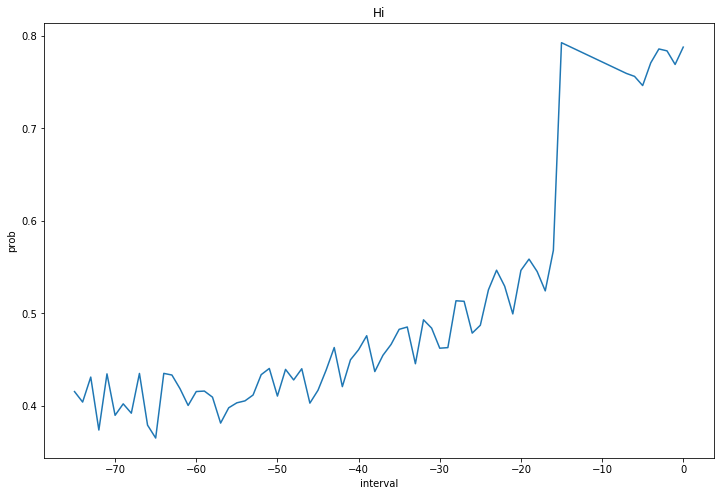

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.relplot(x='interval', y='prob', data=plot_data, kind='line', ax=ax)
ax.set_title("Hi")
plt.close(2)

## Time Sorted

In [ ]:
seed = 43
df = pd.read_csv(args.dataset_csv, parse_dates=['admittime', 'dischtime', 'intime', 'charttime'])
df['relative_charttime'] = (df['charttime'] - df['intime'])
df = set_two_splits(df, 'test', seed=seed)

In [ ]:
train_df = df.loc[(df['split'] == 'train')][['class_label', 'scispacy_note', 'relative_charttime']]
test_df = df.loc[(df['split'] == 'test')][['class_label', 'scispacy_note', 'relative_charttime']]
test_df.sort_values(by='relative_charttime', inplace=True)

In [ ]:
vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True,\
                              ngram_range=(2,2))
x_train = vectorizer.fit_transform(train_df['scispacy_note'])
y_train = train_df['class_label'].to_numpy()

In [ ]:
clf = LogisticRegression(dual=True, class_weight='balanced', solver='liblinear', C=1.5)
clf.fit(x_train, y_train)

In [ ]:
x_test = vectorizer.transform(test_df['scispacy_note'])

In [ ]:
prob = clf.predict_proba(x_test)[:, 1]

In [ ]:
args.bc_threshold

In [ ]:
time = test_df['relative_charttime'].to_numpy()

In [ ]:
time = time/(1e9*60*60)

In [ ]:
plot_df = pd.DataFrame({'time': time, 'prob': prob})

In [ ]:
plot_df.tail()

In [ ]:
import seaborn as sns; sns.set()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.lineplot(x=list(range(len(prob))), y=prob)